# Multi-Modal Data Fusion - Project Work: Multi-Modal Physical Exercise Classification


In this project, real multi-modal data is studied by utilizing different techniques presented during the course. In addition, there is an optional task to try some different approaches to identify persons from the same dataset. Open MEx dataset from UCI machine learning repository is used. Idea is to apply different techniques to recognize physical exercises from wearable sensors and depth camera, user-independently.

## Author(s)
Add your information here

Name(s): amitav 

Student number(s):

## Description 

The goal of this project is to develop user-independent pre-processing and classification models to recognize 7 different physical exercises measured by accelerometer (attached to subject's thigh) and depth camera (above the subject facing downwards recording an aerial view). All the exercises were performed subject lying down on the mat. Original dataset have also another acceleration sensor and pressure-sensitive mat, but those two modalities are ommited in this project. There are totally 30 subjects in the original dataset, and in this work subset of 10 person is utilized. Detailed description of the dataset and original data can be access in [MEx dataset @ UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/MEx#). We are providing the subset of dataset in Moodle.

The project work is divided on following phases:

1. Data preparation, exploration, and visualization
2. Feature extraction and unimodal fusion for classification
3. Feature extraction and feature-level fusion for multimodal classification
4. Decision-level fusion for multimodal classification
5. Bonus task: Multimodal biometric identification of persons

where 1-4 are compulsory (max. 10 points each), and 5 is optional to get bonus points (max. 5+5 points). In each phase, you should visualize and analyse the results and document the work and findings properly by text blocks and figures between the code. <b> Nice looking </b> and <b> informative </b> notebook representing your results and analysis will be part of the grading in addition to actual implementation.

The results are validated using confusion matrices and F1 scores. F1 macro score is given as 
<br>
<br>
$
\begin{equation}
F1_{macro} = \frac{1}{N} \sum_i^N F1_i,
\end{equation}
$
<br>
<br>
where $F1_i = 2  \frac{precision_i * recall_i}{precision_i + recall_i}$, and $N$ is the number of classes.
<br>

## Learning goals 

After the project work, you should  

- be able to study real world multi-modal data
- be able to apply different data fusion techniques to real-world problem
- be able to evaluate the results
- be able to analyse the outcome
- be able to document your work properly

## Relevant lectures

Lectures 1-8

## Relevant exercises

Exercises 0-6

## Relevant chapters in course book

Chapter 1-14

## Additional Material 

* Original dataset [MEx dataset @ UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/MEx#)
* Related scientific article [MEx: Multi-modal Exercises Dataset for Human Activity Recognition](https://arxiv.org/pdf/1908.08992.pdf)

# 1. Data preparation, exploration, and visualization

<a id='task1'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 1.</b>

Download data from the Moodle's Project section. Get yourself familiar with the folder structure and data. You can read the data files using the function given below. Each file consists one exercise type performed by single user. Data are divided on multiple folders. Note that, in each folder there is one long sequence of single exercise, except exercise 4 which is performed two times in different ways. Those two sequences belongs to same class. Do the following subtasks to pre-analyse data examples and to prepare the training and testing data for next tasks:
<br>
<br> 
<p> Read raw data from the files. Prepare and divide each data file to shorter sequences using windowing method. Similar to related article "MEx: Multi-modal Exercises Dataset for Human Activity Recognition", use 5 second window and 3 second overlapping between windows, producing several example sequences from one exercise file for classification purposes. Windowing is working so that starting from the beginning of each long exercise sequence, take 5 seconds of data points (from synchronized acceleration data and depth images) based on the time stamps. Next, move the window 2 seconds forward and take another 5 seconds of data. Then continue this until your are at the end of sequence. Each window will consists 500x3 matrix of acceleration data and 5x192 matrix of depth image data.</p>

</div>

In [66]:
# Import relevant libraries here
from pathlib import Path
from copy import deepcopy
import numpy as np
import pandas as pd

# Enter data folder location
loc = "./MEx"

In [67]:
"""
    IMPORTANT: PLEASE DO NOT MODIFY THE CODE IN THIS CELL.
"""
def path_to_meta(p):
    meta = dict()
    meta["subject_id"] = p.parent.stem
    meta["exercise_id"] = p.stem.split("_")[-2]
    meta["trial"] = int(p.stem.split("_")[-1])
    meta["sensor_code"] = p.stem.split("_")[0]
    meta["sensor"] = {"act": "acc", "dc": "dc"}[meta["sensor_code"]]
    return meta

# Find, read, and compose the measurements
paths_record = Path(loc).glob("*/*/*.csv")

records = []

for path_record in paths_record:
    df = pd.read_csv(path_record, delimiter=",", header=None)
    meta = path_to_meta(path_record)
    
    if meta["sensor"] == "acc":
        col_names = ["time", "acc_0", "acc_1", "acc_2"]
        df.columns = col_names
    else:
        num_cols = df.shape[1]
        col_names = ["time", ] + [f"dc_{i}" for i in range(num_cols-1)]
        df.columns = col_names

    meta["df"] = df
    
    records.append(meta)

df_records = pd.DataFrame.from_records(records)

print(f"Total records found: {len(df_records)}")
print("Dataframe with all records:")
display(df_records.head())
print("Dataframe with one measurement series:")
display(df_records["df"].iloc[0].head())

Total records found: 160
Dataframe with all records:


,subject_id,exercise_id,trial,sensor_code,sensor,df
0,01,01,1,act,acc,time acc_0 acc_1 acc_2 0 ...
1,01,02,1,act,acc,time acc_0 acc_1 acc_2 0 ...
2,01,03,1,act,acc,time acc_0 acc_1 acc_2 0 ...
3,01,04,1,act,acc,time acc_0 acc_1 acc_2 0 ...
4,01,04,2,act,acc,time acc_0 acc_1 acc_2 0 ...


Dataframe with one measurement series:


,time,acc_0,acc_1,acc_2
0,0.0,-0.515625,-0.843750,-0.131944
1,10.0,-0.515625,-0.853125,-0.134375
2,20.0,-0.515625,-0.850000,-0.140625
3,30.0,-0.515625,-0.862500,-0.150000
4,40.0,-0.525000,-0.856250,-0.156250


In [68]:
"""
    IMPORTANT: PLEASE DO NOT MODIFY THE CODE IN THIS CELL.
"""

# Extract 5-second long windows with 2-second shift (3-second overlap)

records_windowed = []

time_window = 5000.
time_offset = 2000.
    
for row_idx, row_data in df_records.iterrows():
    df_tmp = row_data["df"]
    time_start = np.min(df_tmp["time"].to_numpy())
    time_end = np.max(df_tmp["time"].to_numpy())
    
    for window_idx, t0 in enumerate(np.arange(time_start, time_end, time_offset)):
        t1 = t0 + time_window
        # Handle boundary conditions - skip the measurements from the end shorter than window size
        if t1 > time_end:
            continue
        
        tmp_data = deepcopy(row_data)
        tmp_data["window_idx"] = window_idx
        tmp_data["df"] = df_tmp[(df_tmp["time"] >= t0) &
                                (df_tmp["time"] < t1)].copy()
        
        records_windowed.append(tmp_data)
        
df_records_windowed = pd.DataFrame.from_records(records_windowed)

print(f"Total windows extracted: {len(df_records_windowed)}")
print("Dataframe with all windowed records:")
display(df_records_windowed.head())
print("Dataframe with one windowed measurement series:")
display(df_records_windowed["df"].iloc[0].head())

Total windows extracted: 4169
Dataframe with all windowed records:


,subject_id,exercise_id,trial,sensor_code,sensor,df,window_idx
0,01,01,1,act,acc,time acc_0 acc_1 acc_2 0 ...,0
1,01,01,1,act,acc,time acc_0 acc_1 acc_2 200 ...,1
2,01,01,1,act,acc,time acc_0 acc_1 acc_2 400 ...,2
3,01,01,1,act,acc,time acc_0 acc_1 acc_2 60...,3
4,01,01,1,act,acc,time acc_0 acc_1 acc_2 80...,4


Dataframe with one windowed measurement series:


,time,acc_0,acc_1,acc_2
0,0.0,-0.515625,-0.843750,-0.131944
1,10.0,-0.515625,-0.853125,-0.134375
2,20.0,-0.515625,-0.850000,-0.140625
3,30.0,-0.515625,-0.862500,-0.150000
4,40.0,-0.525000,-0.856250,-0.156250


<a id='task1'></a>
<div class=" alert alert-warning">
     
<p> <b>1.1</b> Plot few examples of prepared data for each modalities (accelometer and depth camera). Plot acceleration sensor as multi-dimensional time-series and depth camera data as 2D image. Plot 5 second acceleration sensor and depth image sequences of person 1 and 5 performing exercises 2, 5, and 6. Take the first windowed example from the long exercise sequence. </p>

</div>

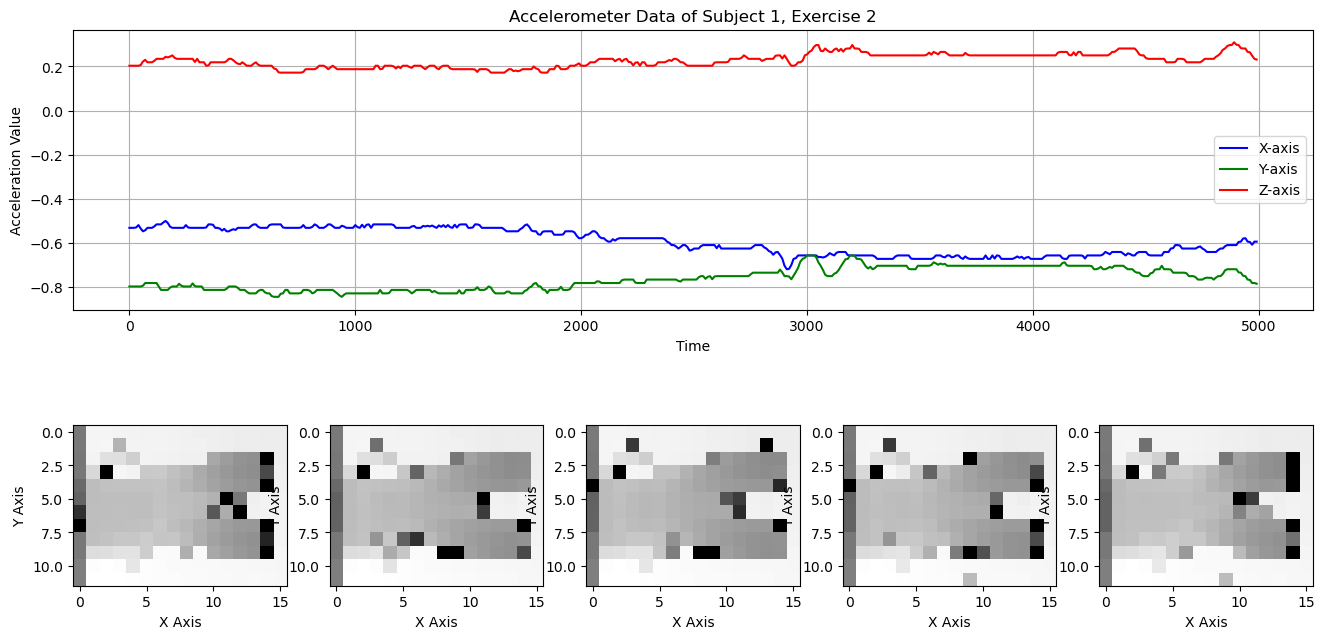

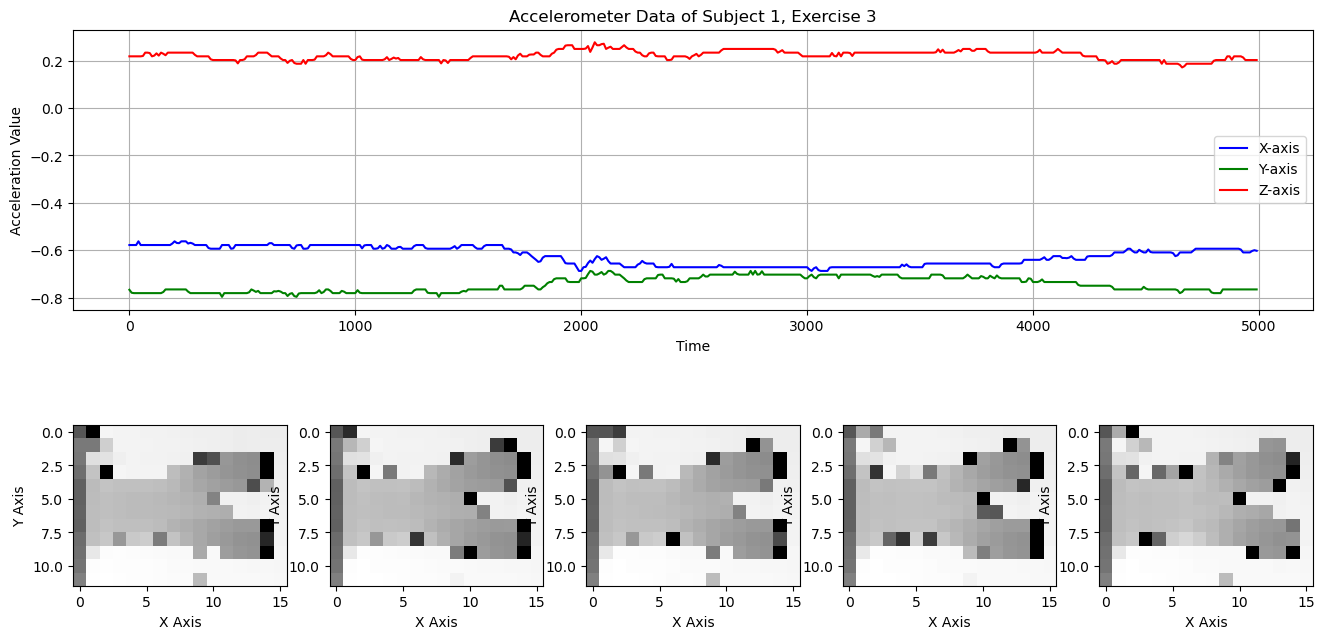

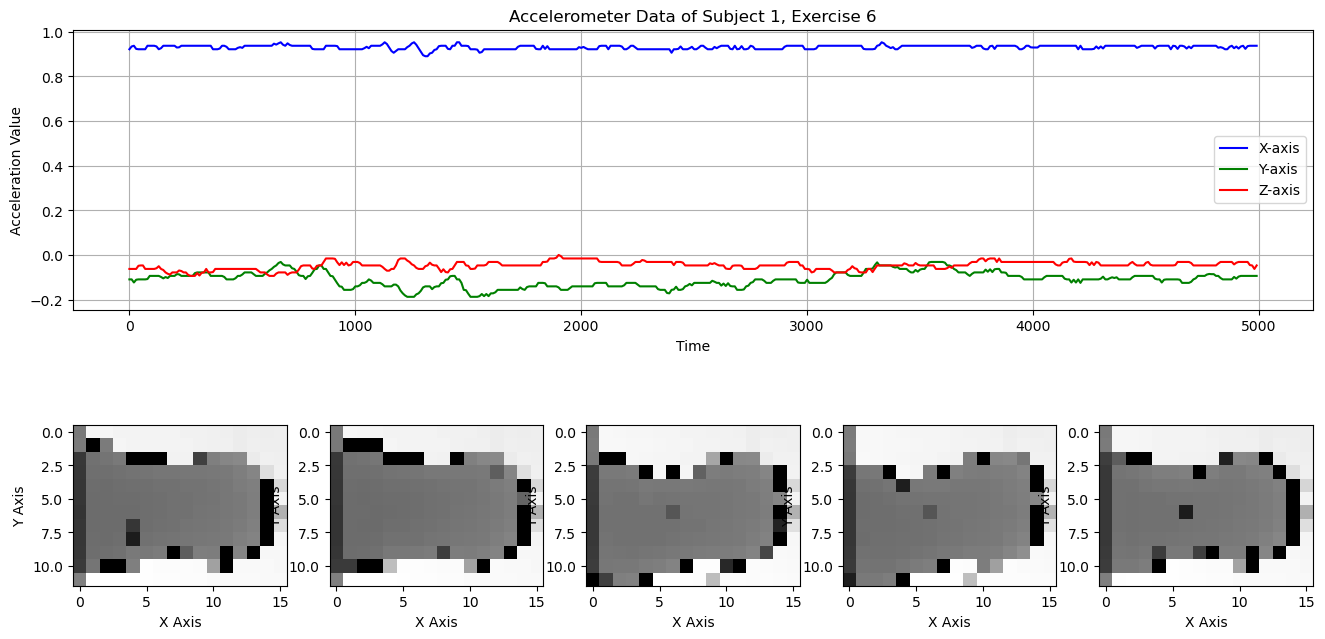

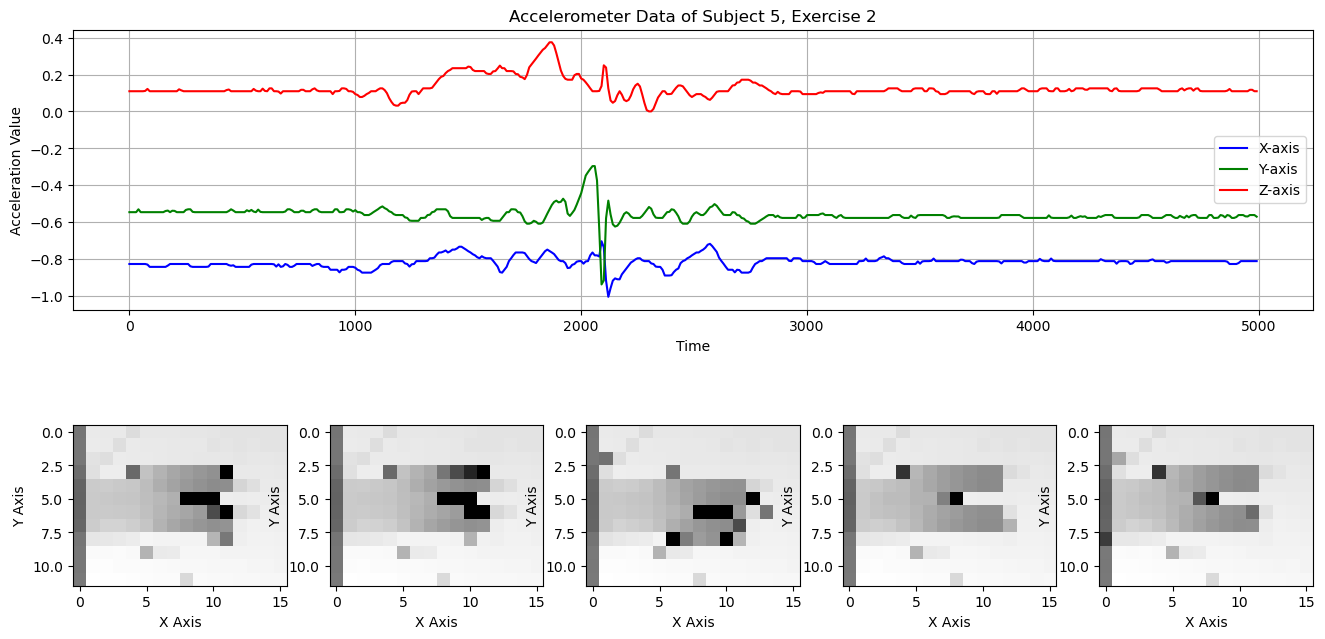

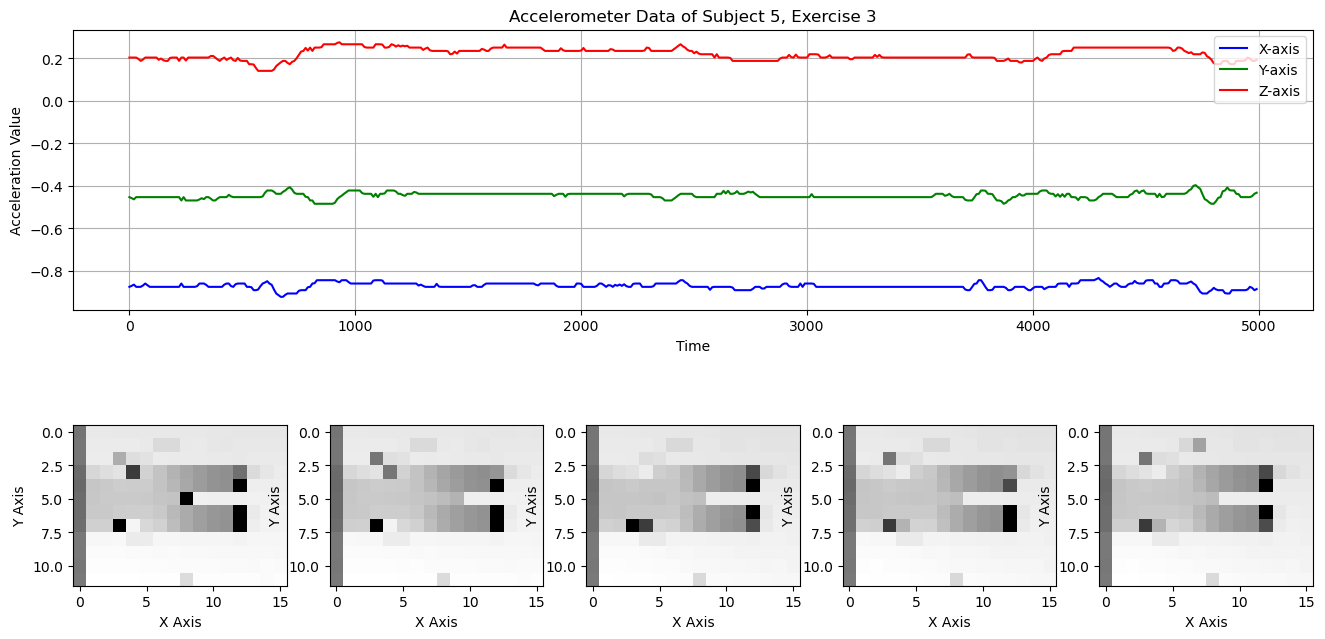

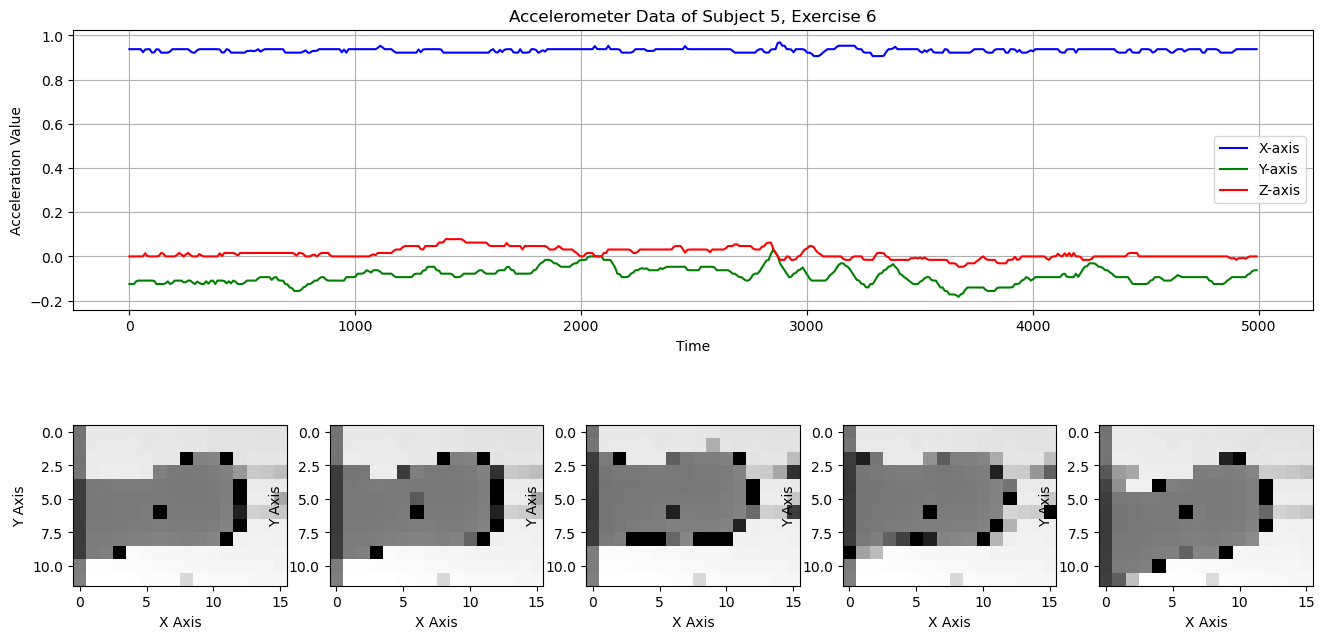

In [69]:
# 1.1. Visualize selected samples for both modalities

### Your code begins here ###

import numpy as np
import matplotlib.pyplot as plt
from itertools import product

def visualize_sensor_data(acc_data, depth_data, subj_id, ex_id):
    # Plot
    fig1_1 = plt.figure(figsize=(16, 8))

    # Subplot for accelerometer
    ax1 = fig1_1.add_subplot(2, 1, 1)  
    ax1.plot(acc_data["time"], acc_data["acc_0"], label='X-axis', color='b')  # Accelerometer data for x-axis
    ax1.plot(acc_data["time"], acc_data["acc_1"], label='Y-axis', color='g')  # Accelerometer data for y-axis
    ax1.plot(acc_data["time"], acc_data["acc_2"], label='Z-axis', color='r')  # Accelerometer data for z-axis
    ax1.set_title(f'Accelerometer Data of Subject {subj_id}, Exercise {ex_id}')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Acceleration Value')
    ax1.legend()
    ax1.grid(True)

    # Subplots for depth data
    for i in range(5):
        ax = fig1_1.add_subplot(2, 5, i + 6)  # Position: row 2, col 1 to 5

        # Plot depth camera data for the i-th exercise
        ax.imshow(depth_data.iloc[i, 1:].to_numpy().reshape((12, 16)), cmap='gray')
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')

# Subjects and exercises to plot
sub = (1, 5) 
exc = (2, 3, 6) 

# Plotting for each subject and exercise combination
for subj_id, ex_id in product(sub, exc):
    filtered_data = df_records_windowed[(df_records_windowed['subject_id'].astype(int) == subj_id) &
                                        (df_records_windowed['exercise_id'].astype(int) == ex_id)]
    acc_data = filtered_data[
        (filtered_data['sensor'] == "acc") &
        (filtered_data['window_idx'].astype(int) == 0)
    ]["df"].iloc[0]

    depth_data = filtered_data[
        (filtered_data['sensor'] == "dc") &
        (filtered_data['window_idx'].astype(int) == 0)
    ]["df"].iloc[0]

    visualize_sensor_data(
        acc_data,
        depth_data,
        subj_id,
        ex_id
    )

### Your code ends here ###

<a id='task1'></a>
<div class=" alert alert-warning">

<p> <b>1.2</b> Split the prepared dataset to training and testing datasets so that data of persons 1-7 are used for training and data of persons 8-10 are used for testing. In next tasks, training dataset could be further divided on (multiple) validation data folds to tune the models parameters, when needed.<br>
    
<p> Note: Training set should have 1486 windows and testing set should have 598 windows. In training set, acceleration data will have a window without a pair with depth camera data, that window should be dropped as it doesn't have a pair.<p>
  
Document your work, calculate the indicator statistics of training and testing datasets (number of examples, dimensions of each example) and visualize prepared examples.

</div>

In [70]:
# 1.2. Split samples based on subject ID into training and testing datasets for futher experiments

### Your code begins here ###

train_subj_ids = range(1, 8)  # training subjects  1-7
test_subj_ids = range(8, 11)  # testing subjects  8-10

# spiliting data for train and test
training_dataset = df_records_windowed[df_records_windowed['subject_id'].astype(int).isin(train_subj_ids)] 
testing_dataset = df_records_windowed[df_records_windowed['subject_id'].astype(int).isin(test_subj_ids)]

#get acc and depth data from tain data
accelerometer_training = training_dataset[training_dataset['sensor'] == "acc"]
depth_camera_training = training_dataset[training_dataset['sensor'] == "dc"]

# Merge acc and depth  data and check for missing pairs
merged_training_data = accelerometer_training.merge(depth_camera_training, on=['subject_id', 'exercise_id', 'trial', 'window_idx'], how='outer', indicator=True)

# Remove training windows without matching accelerometer and depth camera data
incomplete_windows = merged_training_data[merged_training_data['_merge'] != 'both']
for index, window in incomplete_windows.iterrows():
    training_dataset = training_dataset.drop(training_dataset[(training_dataset['subject_id'] == window['subject_id']) &
                                                              (training_dataset['exercise_id'] == window['exercise_id']) &
                                                              (training_dataset['trial'] == window['trial']) &
                                                              (training_dataset['window_idx'] == window['window_idx'])].index)

# print output of number of window samples for each sensor  in training and testing data
print("Training dataset window samples:")
print(f"Depth Camera: {len(training_dataset[training_dataset['sensor'] == 'dc'])}, Accelerometer: {len(training_dataset[training_dataset['sensor'] == 'acc'])}")
print("Testing dataset window samples:")
print(f"Depth Camera: {len(testing_dataset[testing_dataset['sensor'] == 'dc'])}, Accelerometer: {len(testing_dataset[testing_dataset['sensor'] == 'acc'])}")

### Your code ends here ###

Training dataset window samples:
Depth Camera: 1486, Accelerometer: 1486
Testing dataset window samples:
Depth Camera: 598, Accelerometer: 598


# 2. Feature extraction and fusion for unimodal classification

<a id='task2'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 2.</b>

Use the training dataset prepared in task 1. to build models based on the combination of principal component analysis (PCA), linear discriminant analysis (LDA), and nearest neighbour (NN) classifier for each modality separately and evaluate the model on test dataset. Do the subtasks given as 
<br>
<br>
<p> <b>2.1</b> Calculate PCA and LDA transformations to reduce the dimensionality of accelerometer data (e.g., using scikit-learn implementations). Before transformations downsample data from 100 Hz to 25 Hz (using scipy.signal.resample) to get 125x3 matrix of data for each 5 sec window. You should also standardize the values to zero mean and unit variance before the transformations. Using training dataset, fit PCA with 5-dimensional subspace (i.e., choosing the 5 largest principal components) and fit LDA with 5-dimensional subspace. Transform both train and test examples to this low-dimensional feature representation. Concatenate each sequence to single vector size of 3x(5+5). Perform the fusion of PCA and LDA similar manner as presented in Lecture 3 (pages 24-25) using NN method. Evaluate the performance on testset. Show confusion matrix and F1 scores of the results. </p>

Note: Standardize the data along each axis.
<br>

Document your work, evaluate the results, and analyse the outcomes (The expected F1 score for this task should generally fall within the range of 40 to 50)
    
</div>

In [77]:
#2.0 ALL THE FUNCTIONS 

import numpy as np
from scipy.signal import resample
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


""" START OF FUNCTIONS """

#downsampling
def reduce_sampling_rate(data, from_rate, to_rate):
    num_points = data.shape[1]
    new_num_points = int(num_points * to_rate / from_rate)
    reduced_data = resample(data, new_num_points, axis=1)
    return reduced_data

#convert dataframe to array"
def to_numpy_arrays(dataframes):
    numpy_arrays = [df.iloc[:, 1:].values for df in dataframes]
    combined_array = np.array(numpy_arrays)
    return combined_array

#flatten the data
def normalize_data(data):
    flat_data = data.reshape(data.shape[0], -1)
    normalizer = StandardScaler()
    normalized_data = normalizer.fit_transform(flat_data)
    reshaped_data = normalized_data.reshape(data.shape)
    return reshaped_data

#apply pca, lda transformation
def apply_pca_lda(X_train, y_train, X_test, pca_dims, lda_dims):
    pca_lda_train = np.zeros((X_train.shape[0], 3 * 10))  # 3 axes, each transformed to 10 features

    for axis in range(3):  # Iterate over each axis
        axis_data_train = X_train[:, :, axis]
        pca = PCA(n_components=pca_dims)
        pca_features = pca.fit_transform(axis_data_train)
        lda = LDA(n_components=lda_dims)
        lda_features = lda.fit_transform(axis_data_train, y_train)
        pca_lda_train[:, axis*10:(axis+1)*10] = np.concatenate([pca_features, lda_features], axis=1)

    pca_lda_test = np.zeros((X_test.shape[0], 3 * 10))

    for axis in range(3):  # Iterate over each axis
        axis_data_test = X_test[:, :, axis]
        pca_features_test = pca.transform(axis_data_test)
        lda_features_test = lda.transform(axis_data_test)
        pca_lda_test[:, axis*10:(axis+1)*10] = np.concatenate([pca_features_test, lda_features_test], axis=1)

    return pca_lda_train, pca_lda_test

#data fusion of lda, pca features
def fuse_pca_lda(train, labels, test):

    predictions = []
    for example in test:
        distances = np.linalg.norm(train - example, axis=1)
        distances_normalized = (distances - distances.min()) / (distances.max() - distances.min())
        fusion = 0.5 * distances_normalized
        closest_index = np.argmin(fusion)
        predictions.append(labels[closest_index])
    return np.array(predictions)

#process and predict data
def process_predict(train_sensor, test_sensor, labels, pca_size=5, lda_size=5):
    orig_sampling_rate = 100  
    desired_sampling_rate = 25  # downsampling
    reduced_train = reduce_sampling_rate(train_sensor, orig_sampling_rate, desired_sampling_rate)
    reduced_test = reduce_sampling_rate(test_sensor, orig_sampling_rate, desired_sampling_rate)
    normalized_train = normalize_data(reduced_train)
    normalized_test = normalize_data(reduced_test)
    pca_lda_train, pca_lda_test = apply_pca_lda(normalized_train, labels, normalized_test, pca_size, lda_size)
    predictions = fuse_pca_lda(pca_lda_train, labels, pca_lda_test)
    return predictions

# Process and predict using depth sensor data
def process_predict_depth(train_data, test_data, labels, pca_size=5, lda_size=5):
    # Normalize training and testing data
    normalized_train = normalize_data(train_data)
    normalized_test = normalize_data(test_data)

    # Transform data using PCA and LDA
    transformed_train, transformed_test = transform_depth_data(normalized_train, labels, normalized_test, pca_size, lda_size)

    # Fuse PCA and LDA features for prediction
    predicted_labels = fuse_pca_lda(transformed_train, labels, transformed_test)
    return predicted_labels


#find f1 score
def compute_f1_score(actual, predicted):

    classes = set(actual)
    f1_total = 0

    for cls in classes:
        tp = sum((y_act == cls and y_pred == cls) for y_act, y_pred in zip(actual, predicted))
        fp = sum((y_act != cls and y_pred == cls) for y_act, y_pred in zip(actual, predicted))
        fn = sum((y_act == cls and y_pred != cls) for y_act, y_pred in zip(actual, predicted))
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_cls = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
        f1_total += f1_cls

    f1_avg = f1_total / len(classes)
    return f1_avg

#show confusion matrix
def display_confusion_matrix(actual_labels, predicted_labels, class_labels=None):
    
    conf_matrix = confusion_matrix(actual_labels, predicted_labels, labels=class_labels)
    matrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
    plt.figure(figsize=(8, 6))
    matrix_display.plot(cmap='viridis', values_format='d')  # Changed color map to 'viridis'
    plt.title('Accelerometer Data Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show();

    
# Transform depth sensor data using PCA and LDA
def transform_depth_data(train_data, train_labels, test_data, pca_components, lda_components):
    # Initialize arrays for transformed training data
    train_transformed = np.zeros((train_data.shape[0], 5 * (pca_components + lda_components)))  # 5 images, each with transformed features

    # Apply PCA and LDA to each depth image
    for img_index in range(5):
        image_data = train_data[:, img_index, :].reshape(train_data.shape[0], -1)
        pca = PCA(n_components=pca_components)
        image_pca = pca.fit_transform(image_data)
        lda = LDA(n_components=lda_components)
        image_lda = lda.fit_transform(image_data, train_labels)
        train_transformed[:, img_index*10:(img_index+1)*10] = np.concatenate([image_pca, image_lda], axis=1)

    # Initialize arrays for transformed test data
    test_transformed = np.zeros((test_data.shape[0], 5 * (pca_components + lda_components)))

    for img_index in range(5):
        image_data_test = test_data[:, img_index, :].reshape(test_data.shape[0], -1)
        image_pca_test = pca.transform(image_data_test)
        image_lda_test = lda.transform(image_data_test)
        test_transformed[:, img_index*10:(img_index+1)*10] = np.concatenate([image_pca_test, image_lda_test], axis=1)

    return train_transformed, test_transformed



""" END OF FUCTIONS """


' END OF FUCTIONS '

<Figure size 800x600 with 0 Axes>

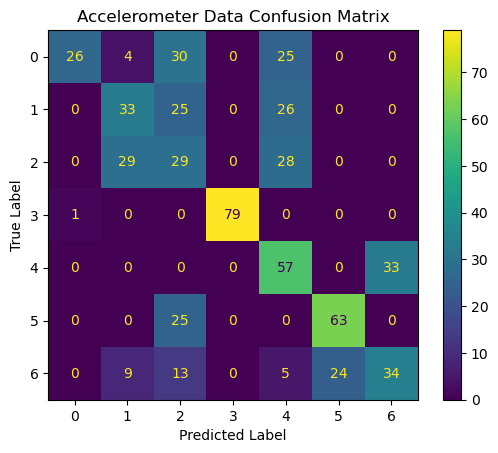

F1 Score: 0.5446874020196477


In [78]:
# 2.1

### Your code begins here ###

# filter and prepare accelerometer dataset 
filtered_train_data = training_dataset[training_dataset["sensor"] == "acc"]
filtered_test_data = testing_dataset[testing_dataset["sensor"] == "acc"]

X_train_sensor, X_test_sensor, y_train_labels, y_test_labels = (
    to_numpy_arrays(filtered_train_data["df"].tolist()),
    to_numpy_arrays(filtered_test_data["df"].tolist()),
    filtered_train_data["exercise_id"].to_numpy(),
    filtered_test_data["exercise_id"].to_numpy()
)

predicted_sensor_labels = process_predict(X_train_sensor, X_test_sensor, y_train_labels, pca_size=5, lda_size=5) #predict for acc data

f1_score_acc = compute_f1_score(y_test_labels, predicted_sensor_labels) #calculate f1 score

display_confusion_matrix(y_test_labels, predicted_sensor_labels) #show confusion matrix

print(f"F1 Score: {f1_score_acc}") #print f1 score

### Your code ends here ###

<a id='task2'></a>
<div class=" alert alert-warning">
<p> <b>2.2</b> Use PCA and LDA transformations to reduce the dimensionality of depth images. You should also standardize the values to zero mean and unit variance before the transformations. Fit PCA and LDA for all training images (12x16, 192-dimensional in vectorized form) by choosing 5-dimensional subspace for both PCA and LDA. Transform both train and test examples to this low-dimensional feature representation. Concatenate each sequence to single vector size of 5x1x(5+5). Similar to task 2.1, do the PCA and LDA fusion using NN and evaluate the performance on testset. Show confusion matrix and F1 scores of the results. </p>

Note: Standardize the data along each axis.
<br>

Document your work, evaluate the results, and analyse the outcomes (The expected F1 score for this task should generally fall within the range of 40 to 50)
    
</div>

<Figure size 800x600 with 0 Axes>

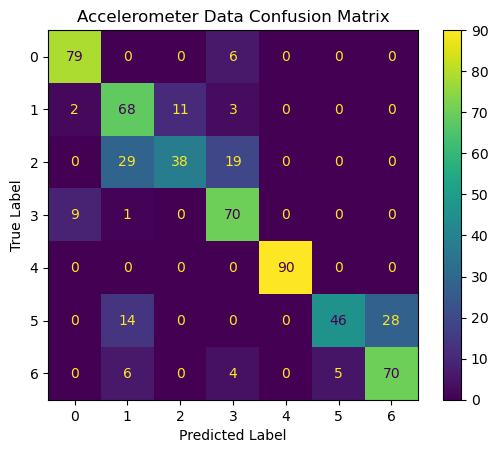

Depth Sensor F1 Score: 0.7621737182550061


In [79]:
# 2.2

### Your code begins here ###

# """ START OF FUNCTIONS """
#moved to 2.0 
# """ END OF FUNCTIONS """

# Filter and prepare depth dataset
filtered_train_dc = training_dataset[training_dataset["sensor"] == "dc"]
filtered_test_dc = testing_dataset[testing_dataset["sensor"] == "dc"]

# Extract data and labels for depth data
X_train_depth, X_test_depth, y_train_depth, y_test_depth = (
    to_numpy_arrays(filtered_train_dc["df"].tolist()),
    to_numpy_arrays(filtered_test_dc["df"].tolist()),
    filtered_train_dc["exercise_id"].to_numpy(),
    filtered_test_dc["exercise_id"].to_numpy()
)

# Predict using depth cam data 
predicted_depth_labels = process_predict_depth(X_train_depth, X_test_depth, y_train_depth, pca_size=5, lda_size=5)

f1_score_depth = compute_f1_score(y_test_depth, predicted_depth_labels) #calculate f1 score for depth cam data

# Display confusion matrix for depth sensor data
display_confusion_matrix(y_test_depth, predicted_depth_labels) #show confusion matrix for depth cam data

print(f"Depth Sensor F1 Score: {f1_score_depth}") # print F1 score for depth sensor data

### Your code ends here ### 


# 3. Feature extraction and feature-level fusion for multimodal classification

<a id='task3'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 3.</b>

Prepare new feature sets for each modality and combine them to single feature representation. Compare two classifiers from scikit-learn. Train classifiers using joint feature presentation. Evaluate and compare the result using testing dataset. Do the subtasks given as 
<br>   

<p> <b>3.1</b> Similar to task 2.1, calculate PCA for accelerometer, but choose now the 10 largest principal components as 10-dim feature vector for each window. In addition, for each window calculate mean and standard deviation of each three acc channels as statistical features, resulting 6-dimensional vector. Combine these to 36-dimensional final feature vector.</p>

Document your work.
    
</div>

In [80]:
# 3.1

### Your code begins here ###
import numpy as np
from sklearn.decomposition import PCA

""" START OF FUNCTIONS """

# PCA Transformation for acc data
def pca_transform_accelerometer(X_train, y_train, X_test, pca_dims=10):
    # initialize
    train_pca_transformed = np.zeros((X_train.shape[0], 3 * pca_dims))  # 3 axes, each with PCA features

    # apply PCA to acc data
    for axis in range(3):
        axis_data_train = X_train[:, :, axis]
        pca = PCA(n_components=pca_dims)
        axis_pca = pca.fit_transform(axis_data_train)
        train_pca_transformed[:, axis*10:(axis+1)*10] = axis_pca

    test_pca_transformed = np.zeros((X_test.shape[0], 3 * pca_dims))

    for axis in range(3):
        axis_data_test = X_test[:, :, axis]
        axis_pca_test = pca.transform(axis_data_test)
        test_pca_transformed[:, axis*10:(axis+1)*10] = axis_pca_test

    return train_pca_transformed, test_pca_transformed

#  mean and std deviation for acc data
def calculate_mean_std(data):
    mean_per_axis = np.mean(data, axis=1)  # Mean along each axis
    std_per_axis = np.std(data, axis=1)    # Standard deviation along each axis
    concatenated_features = np.concatenate((mean_per_axis, std_per_axis), axis=1)
    return concatenated_features

""" END OF FUNCTIONS """

# Apply PCA transformation to accelerometer data
train_pca_acc, test_pca_acc = pca_transform_accelerometer(X_train_sensor, y_train_labels, X_test_sensor, pca_dims=10)

# get mean and standard deviation for accelerometer data
train_mean_std_acc, test_mean_std_acc = calculate_mean_std(X_train_sensor), calculate_mean_std(X_test_sensor)

# Concatenate transformed(pca) data with mean and standard deviation 
train_pca_mean_std_acc = np.concatenate((train_pca_acc, train_mean_std_acc), axis=1)
test_pca_mean_std_acc = np.concatenate((test_pca_acc, test_mean_std_acc), axis=1)

print(f"Transformed Train Data Shape (PCA + Mean/Std): {train_pca_mean_std_acc.shape}") # print the shape of transformed data

### Your code ends here ###

Transformed Train Data Shape (PCA + Mean/Std): (1486, 36)


<a id='task3'></a>
<div class=" alert alert-warning">

<p> <b>3.2</b> Similar to task 2.2, calculate the PCA for depth images using same setup, but now choose the 10 largest principal components as feature vector. Concatenate the image sequence forming 50-dimensional feature vector from each windowed example.</p>

Document your work.
    
</div>

In [81]:
# 3.2

### Your code begins here ###


# pca transform for depth data
def pca_transform_depth_data(train_data, train_labels, test_data, pca_dims=10):
    # initialize array
    train_pca_transformed = np.zeros((train_data.shape[0], 5 * pca_dims))  # 5 depth images, each with PCA features

    # apply pca
    for img_index in range(5):
        image_data = train_data[:, img_index, :].reshape(train_data.shape[0], -1)
        pca = PCA(n_components=pca_dims)
        image_pca = pca.fit_transform(image_data)
        train_pca_transformed[:, img_index*10:(img_index+1)*10] = image_pca

    test_pca_transformed = np.zeros((test_data.shape[0], 5 * pca_dims))

    for img_index in range(5):
        image_data_test = test_data[:, img_index, :].reshape(test_data.shape[0], -1)
        image_pca_test = pca.transform(image_data_test)
        test_pca_transformed[:, img_index*10:(img_index+1)*10] = image_pca_test

    return train_pca_transformed, test_pca_transformed


# Apply PCA to depth data
train_pca_depth, test_pca_depth = pca_transform_depth_data(X_train_depth, y_train_depth, X_test_depth, pca_dims=10)

print(f"Transformed Train Data Shape (Depth Sensor, PCA): {train_pca_depth.shape}") #print shape of transformed data(depth sensor)

### Your code ends here ###

Transformed Train Data Shape (Depth Sensor, PCA): (1486, 50)


<a id='task3'></a>
<div class=" alert alert-warning">

<p> <b>3.3</b> Form a joint feature presentation of features extracted in 3.1 and 3.2, resulting 86-dimensional feature vector for each example. Normalize data between 0-1 using the training dataset. Use support vector machine (SVM) with RBF-kernel and Gaussian naiveBayes classifier (use default parameter values for both classifiers). Train the classifiers and evaluate and compare classifiers on testset using confusion matrices and F1 scores.</p>

Note: Normalize the data along each axis.
<br>

Document your work, evaluate the results, and analyse the outcomes. (The expected F1 score for this task should generally fall within the range of 55 to 70)
    
</div>

Confusion Matrix for SVM:


<Figure size 800x600 with 0 Axes>

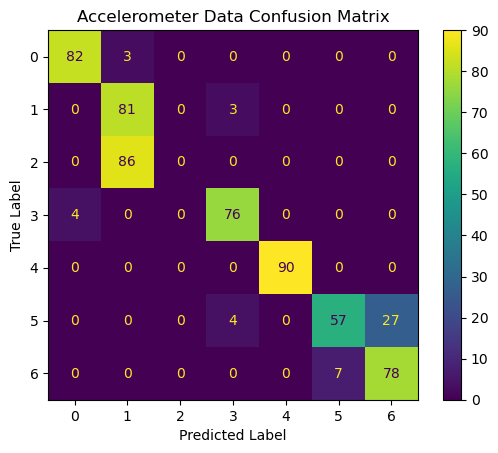

SVM F1 Score: 0.7286325102968844
Confusion Matrix for Naive Bayes:


<Figure size 800x600 with 0 Axes>

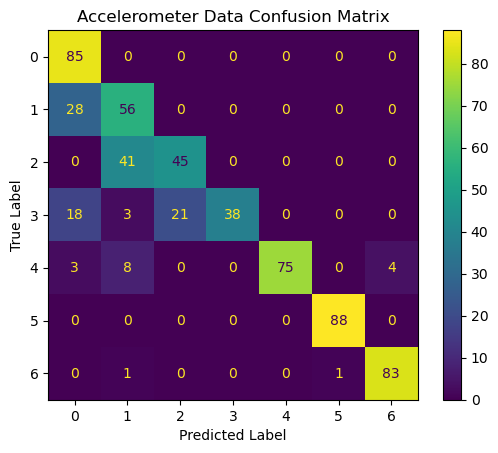

Naive Bayes F1 Score: 0.7801853027151698


In [82]:
# 3.3

### Your code begins here ###

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score


# fit and return a MinMaxScaler
def fit_normalize_data(X_train):
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    return scaler


# concatenating transformed(pca) for acc and depth data
X_train_combined = np.concatenate((train_pca_mean_std_acc, train_pca_depth), axis=1)
X_test_combined = np.concatenate((test_pca_mean_std_acc, test_pca_depth), axis=1)

# normalize training and test data
scaler = fit_normalize_data(X_train_combined)
normalized_X_train = scaler.transform(X_train_combined)
normalized_X_test = scaler.transform(X_test_combined)

# SVM with RBF kernel
svm_model = SVC(kernel='rbf')
svm_model.fit(normalized_X_train, y_train_labels)

# gaussian naive bayes classifier
nb_model = GaussianNB()
nb_model.fit(normalized_X_train, y_train_labels)

# Predictions using SVM and Naive Bayes
svm_predictions = svm_model.predict(normalized_X_test)
nb_predictions = nb_model.predict(normalized_X_test)

# apply SVM
svm_f1 = f1_score(y_test_labels, svm_predictions, average='macro')
print("Confusion Matrix for SVM:")
display_confusion_matrix(y_test_labels, svm_predictions)
print(f"SVM F1 Score: {svm_f1}")

# apply Naive Bayes
nb_f1 = f1_score(y_test_labels, nb_predictions, average='macro')
print("Confusion Matrix for Naive Bayes:")
display_confusion_matrix(y_test_labels, nb_predictions)
print(f"Naive Bayes F1 Score: {nb_f1}")

### Your code ends here ###



# 4. Decision-level fusion for multimodal classification

<a id='task4'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 4.</b>

Use features calculated for each modality in task 3. Choose base classifier for each modality from scikit-learn. Train classifiers for each modality feature presentations separately and combine the outputs in decision level. Evaluate and compare the result on testing dataset. Do the subtasks given as 
<br>
<br> 
<p> <b>4.1</b> Use base classifiers of support vector machine (SVM) with RBF-kernel and AdaBoost classifier (with random_state=0). 
Normalize data between 0-1 using the training dataset. Train the base classifiers by tuning the model parameters (<i>C</i> parameter and RBF-kernel <i>gamma</i> in SVM as well as <i>n_estimators</i> and <i>learning_rate</i> in Adaboost) using 10-fold cross-validation on training dataset to find optimal set of parameters (hint: use GridSearchCV from scikit-learn). For grid search use the following values $C = [0.1, 1.0, 10.0, 100.0]$, $gamma=[0.1, 0.25, 0.5, 0.75, 1.0, 2.0]$, $n\_estimators = [50, 100, 500, 1000]$, and $learning\_rate = [0.1, 0.25, 0.5, 0.75,1.0]$.<br>
Choose the best parameters and train the classifiers for each modality on whole training dataset. Is there a possibility that classifiers will overfit to training data using this parameter selection strategy? If so, why? </p>

Note: Normalize the data along each axis.
<br>

Document your work, answer the given question, evaluate the results, and analyse the outcomes.
    
</div>

In [ ]:
# 4.1

### Your code begins here ###

### Your code ends here ###

<a id='task4'></a>
<div class=" alert alert-warning">


<p> <b>4.2</b> Predict probabilistic outputs of each trained classifier for both modalities using the test set. </p>
<br>
Document your work, evaluate the results, and analyse the outcomes.
    
</div>

In [ ]:
# 4.2

### Your code begins here ###

### Your code ends here ###

<a id='task4'></a>
<div class=" alert alert-warning">
<p> <b>4.3</b> Combine the probabilistic outputs of different modalities by fixed classification rules: max, min, prod, and sum. Evaluate, compare, and analyse the final combined results using confusion matrices and F1 scores. Show results for each base classifier combinations (i.e., $SVM_{acc}+SVM_{depth}$, $AdaBoost_{acc}+AdaBoost_{depth}$, $SVM_{acc}+AdaBoost_{depth}$, $AdaBoost_{acc}+SVM_{depth}$)</p>
<br>
Document your work, evaluate the results, and analyse the outcomes.
    
</div>

In [ ]:
# 4.3

### Your code begins here ###

### Your code ends here ###

# 5. Bonus task: Multimodal biometric identification of persons (optional)

<a id='task5'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 5.</b>

Can you build a classifier that recognizes the person who is performing the exercise? Use same 10 person dataset and split it so that first 25% of each long exercise sequence is used for training and rest 75% of each sequence is used for testing the classifier. Use same 5 second windowing with 3 seconds overlap to prepare the examples. Note that, now the person identity is the class label instead of exercise type. Max. 10 points are given but you can earn points from partial solution, as well.
<br> 
<br> 
<p> <b>5.1</b> Build a classifier to identify persons based on the features and one of the models given in task 4 (max. 5 points).</p>
<br> 
Document your work. Evaluate and compare the results using confusion matrix and F1 score.

</div>

In [ ]:
# 5.1

### Your code begins here ###

### Your code ends here ###

<a id='task5'></a>
<div class=" alert alert-warning">

<p> <b>5.2</b> Can you build your own solution (using new features, new classification model or different fusion approaches) to beat the approach in Task 5.1 ? (max. 5 points) </p>
<br>  
Document your work. Evaluate and compare the results using confusion matrix and F1 score.

</div>

In [ ]:
# 5.2

### Your code begins here ###

### Your code ends here ###